In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import pickle

from tensorflow import keras
from keras import models, layers
from keras.models import load_model

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from qiskit.visualization import plot_histogram 
import seaborn as sns
from collections import defaultdict

pd.options.display.float_format = '{:,.15f}'.format

In [4]:
def NN_model(n_qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'relu', d = 0.0):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, input_shape = (2 ** n_qubit, )))

    for i in range(n_hidden_layer):
        model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation))
        #model.add(layers.Dropout(d))
            
    model.add(layers.Dense(2 ** n_qubit, activation = 'softmax'))
    
    return model

def transform(n_data, times, x, n_qubits):

    for i in range(times):
        for j in range(n_data):
            for k in range(2**n_qubits):
                bit_i = str(bin(k)[2:]).zfill(n_qubits)
                if bit_i not in x[i][j]:
                    x[i][j][bit_i] = 0
                if i == 0 and j == 0:
                    x[i][j][bit_i] = [x[i][j][bit_i]]

    df = pd.DataFrame(x[0][0])

    for i in range(1, n_data ):
        df = df.append(pd.Series(x[0][i], index = df.columns), ignore_index = True)
    for i in range(1, times):
        for j in range(0, n_data):
            df = df.append(pd.Series(x[i][j], index = df.columns), ignore_index = True)
    col = []
    for i in range(2**n_qubits):
        bit_i = str(bin(i)[2:]).zfill(n_qubits)
        col.append(bit_i)
    df = df[col] 
    
    return df

def load_file(n_qubits, times, device_type, number): # return 값 확인
    
    file_path = './' + device_type + '_' + str(n_qubits) +  'qubits_ideal_' + str(number) + '.json'
    file_path_1 = './' + device_type + '_' + str(n_qubits) + 'qubits_obs_' + str(number) + '.json'
    
    Y = 0
    with open(file_path, "r") as json_file:
        Y = json.load(json_file)
    X = 0
    with open(file_path_1, "r") as json_file:
        X = json.load(json_file)

    return X, Y

def load_data(n_qubits, n_data, times, device_type, number):

    X = [0 for i in range(len(n_qubits))]
    Y = [0 for i in range(len(n_qubits))]

    for i in range(len(n_qubits)):
        X[i], Y[i] = load_file(n_qubits[i], times[i], device_type, number)
        X[i] = transform(n_data, times[i], X[i], n_qubits[i])
        Y[i] = transform(n_data, times[i], Y[i], n_qubits[i])
        
    return X, Y

def LI_QREM(n_qubits, times, n_data, device_type, number, X):
        
    file_path_2 = './' + device_type + '_' + str(n_qubits) + 'qubits_meas_' + str(number) + '.p'
    
    with open(file_path_2, 'rb') as file:
        meas = pickle.load(file)
        
    LI = []
    for i in range(times):
        miti = []
        for j in range(n_data):
            row_dict = X.iloc[(n_data * i) + j].to_dict()
            miti.append(meas.filter.apply(row_dict))
        LI.append(miti)
    
    LI = transform(n_data, times, LI, n_qubits)

    return LI

def loss_function(p_ideal, p_mitigated, n_qubit):
    MSE = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
             x += (abs(p_mitigated[i][j] - p_ideal[i][j]) ** 2)
        x /= 2**n_qubit
        MSE += x
    MSE /= len(p_mitigated)

    KLD = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            if p_ideal[i][j] < 1e-15 or p_mitigated[i][j] < 1e-15:
                x += 0
            else:
                x += p_ideal[i][j] * (math.log(p_ideal[i][j]) - math.log(p_mitigated[i][j]))
        KLD += x
    KLD /= len(p_mitigated)
    
    IF = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            x += math.sqrt(p_ideal[i][j] * p_mitigated[i][j])
        IF += (1 - x**2)
    IF /= len(p_mitigated)

    return MSE, KLD, IF
def create_x(t, w, n, d):
    return [t * x + w * n for x in range(d)]

def show_plot(topics, unmitigated, LI, NN, type = 0, label = ['unmitigated', 'LI', 'NN']):
    n = 1  # This is our first dataset (out of 2)
    t = 3 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d)
    value_c_x = create_x(t, w, 3, d)

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [LI[0][type]]
    x_3 = [NN[0][type]]
    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black')
    ax.bar(value_c_x, x_3, label = label[2], color = 'white', edgecolor = 'black', hatch = '/////')

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks(value_b_x)
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()
    
def get_train_test(x, y, mit, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_miti= mit.sample(n_data, random_state = random_state)
    test_miti = mit.drop(train_miti.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    train_miti.reset_index(drop = True, inplace = True)
    test_miti.reset_index(drop = True, inplace = True)

    return train_x, test_x, train_y, test_y, train_miti, test_miti

In [523]:
def marginal(Q, n_data, time):
    x_0 = [] # d = 0일때 나머지 6bit 
    x_1 = [] # d = 1일때 나머지 6bit 
    x_2 = [] # d  (0 or 1)
    
    x_3 = [] # d = 0일때 앞 3bit 
    x_4 = [] # d = 0일때 뒤 3bit 
    x_5 = [] # d = 1일때 앞 3bit 
    x_6 = [] # d = 1일때 뒤 3bit 
    for i in range(time):
        a0 = []
        a1 = []
        a2 = []
        
        a3 = []
        a4 = []        
        a5 = []
        a6 = []
        for j in range(n_data):
            marginal_dict_m0_0 = {} # d = '0', 6bit
            marginal_dict_m1_0 = {} # d = '1', 6bit
            marginal_dict_m0_2 = {} # d

            marginal_dict_m0_3 = {} # d = '0', 3bit
            marginal_dict_m1_3 = {} # d = '1', 3bit
            marginal_dict_m0_4 = {} # d = '0', 3bit
            marginal_dict_m1_4 = {} # d = '1', 3bit

            for key, value in Q[i][j].items():

                if key[3] == '0':
                    if key[:3] + key[4:] not in marginal_dict_m0_0:
                       marginal_dict_m0_0[key[:3] + key[4:]] = value
                    elif  key[:3] + key[4:] in marginal_dict_m0_0:
                       marginal_dict_m0_0[key[:3] + key[4:]] += value
                       
                    if key[3] not in marginal_dict_m0_2:
                       marginal_dict_m0_2[key[3]] = value
                    elif key[3] in marginal_dict_m0_2:
                       marginal_dict_m0_2[key[3]] += value
                       
                else:
                    if key[:3] + key[4:] not in marginal_dict_m1_0:
                       marginal_dict_m1_0[key[:3] + key[4:]] = value
                    elif  key[:3] + key[4:] in marginal_dict_m1_0:
                       marginal_dict_m1_0[key[:3] + key[4:]] += value
                       
                    if key[3] not in marginal_dict_m0_2:
                       marginal_dict_m0_2[key[3]] = value
                    elif key[3] in marginal_dict_m0_2:
                       marginal_dict_m0_2[key[3]] += value
                    
            total_prob_0 = sum(marginal_dict_m0_0.values()) 
            total_prob_1 = sum(marginal_dict_m1_0.values()) 
            total_prob_2 = sum(marginal_dict_m0_2.values())                
            marginal_dict_m0_0 = {key: value / total_prob_0 for key, value in marginal_dict_m0_0.items()}
            marginal_dict_m1_0 = {key: value / total_prob_1 for key, value in marginal_dict_m1_0.items()}
            marginal_dict_m0_2 = {key: value / total_prob_2 for key, value in marginal_dict_m0_2.items()}
            
            a0.append(marginal_dict_m0_0)
            a1.append(marginal_dict_m1_0)            
            a2.append(marginal_dict_m0_2)
            
            for key, value in marginal_dict_m0_0.items():
               if key[:3] not in marginal_dict_m0_3:
                  marginal_dict_m0_3[key[:3]] = value
               elif key[:3] in marginal_dict_m0_3:
                  marginal_dict_m0_3[key[:3]] += value
                  
               if key[3:] not in marginal_dict_m0_4:
                  marginal_dict_m0_4[key[3:]] = value
               elif key[3:] in marginal_dict_m0_4:
                  marginal_dict_m0_4[key[3:]] += value

            for key, value in marginal_dict_m1_0.items():
               if key[:3] not in marginal_dict_m1_3:
                  marginal_dict_m1_3[key[:3]] = value
               elif key[:3] in marginal_dict_m1_3:
                  marginal_dict_m1_3[key[:3]] += value
                  
               if key[3:] not in marginal_dict_m1_4:
                  marginal_dict_m1_4[key[3:]] = value
               elif key[3:] in marginal_dict_m1_4:
                  marginal_dict_m1_4[key[3:]] += value
                    
            a3.append(marginal_dict_m0_3)            
            a4.append(marginal_dict_m0_4)
            a5.append(marginal_dict_m1_3)            
            a6.append(marginal_dict_m1_4)
                                
        x_0.append(a0)
        x_1.append(a1)
        x_2.append(a2)
        
        x_3.append(a3)
        x_4.append(a4)    
        x_5.append(a5)
        x_6.append(a6)
        
    return x_0, x_1, x_2, x_3, x_4, x_5, x_6

In [5]:
n_qubits = [7]
n_data = 300
times = [9]
device_type = 'ibm_lagos'
number = 0

X, Y= load_data(n_qubits, n_data, times, device_type, number)

In [ ]:
LI = LI_QREM(n_qubits[0], times[0], n_data, device_type, number, X[0])

In [ ]:
X[0].to_csv('ibm_lagos_7qubits_obs_0.csv', index=False, header=True)
Y[0].to_csv('ibm_lagos_7qubits_ideal_0.csv', index=False, header=True)
LI.to_csv('ibm_lagos_7qubits_miti_0.csv', index=False, header=True)

In [ ]:
df = pd.read_csv("ibm_lagos_7qubits_ideal_0.csv")
df2 = pd.read_csv("ibm_lagos_7qubits_obs_0.csv")
df3 = pd.read_csv("ibm_lagos_7qubits_miti_0.csv")


In [524]:
X_cond, Y_cond = load_file(n_qubits[0], times[0], device_type, number)

x_gfecba_given_d0, x_gfecba_given_d1, x_d, x_gfe_given_d0, x_cba_given_d0, x_gfe_given_d1, x_cba_given_d1 = marginal(X_cond, n_data, times[0])
y_gfecba_given_d0, y_gfecba_given_d1, y_d, y_gfe_given_d0, y_cba_given_d0, y_gfe_given_d1, y_cba_given_d1 = marginal(Y_cond, n_data, times[0])

In [545]:
Y_cond[0][0]['0011011']

0.0038549449754904604

In [541]:
qq = []
for k in range(300):
    prob = {}
    for i in range(2**3):
        bit_i = str(bin(i)[2:]).zfill(3)
        for j in range(2**3):
            bit_j = str(bin(j)[2:]).zfill(3)
            prob[bit_i + '0' + bit_j] = y_gfe_given_d0[0][k][bit_i] * y_cba_given_d0[0][k][bit_j] * y_d[0][k]['0']
            prob[bit_i + '1' + bit_j] = y_gfe_given_d1[0][k][bit_i] * y_cba_given_d1[0][k][bit_j] * y_d[0][k]['1']
    qq.append(prob)
 

In [544]:
qq[0]['0011011']

0.003854944975490464

In [546]:
x_gfe_given_d0 = transform(n_data, times[0], x_gfe_given_d0, 3)
x_cba_given_d0 = transform(n_data, times[0], x_cba_given_d0, 3)
x_gfe_given_d1 = transform(n_data, times[0], x_gfe_given_d1, 3)
x_cba_given_d1 = transform(n_data, times[0], x_cba_given_d1, 3)

y_gfe_given_d0 = transform(n_data, times[0], y_gfe_given_d0, 3)
y_cba_given_d0 = transform(n_data, times[0], y_cba_given_d0, 3)
y_gfe_given_d1 = transform(n_data, times[0], y_gfe_given_d1, 3)
y_cba_given_d1 = transform(n_data, times[0], y_cba_given_d1, 3)

x_d = transform(n_data, times[0], x_d, 1)
y_d = transform(n_data, times[0], y_d, 1)


In [547]:
x_gfe_given_d0.to_csv('ibm_lagos_7qubits_obs_gfe_given_d0.csv', index=False, header=True)
x_cba_given_d0.to_csv('ibm_lagos_7qubits_obs_cba_given_d0.csv', index=False, header=True)
x_gfe_given_d1.to_csv('ibm_lagos_7qubits_obs_gfe_given_d1.csv', index=False, header=True)
x_cba_given_d1.to_csv('ibm_lagos_7qubits_obs_cba_given_d1.csv', index=False, header=True)

y_gfe_given_d0.to_csv('ibm_lagos_7qubits_ideal_gfe_given_d0.csv', index=False, header=True)
y_cba_given_d0.to_csv('ibm_lagos_7qubits_ideal_cba_given_d0.csv', index=False, header=True)
y_gfe_given_d1.to_csv('ibm_lagos_7qubits_ideal_gfe_given_d1.csv', index=False, header=True)
y_cba_given_d1.to_csv('ibm_lagos_7qubits_ideal_cba_given_d1.csv', index=False, header=True)

x_d.to_csv('ibm_lagos_7qubits_obs_d.csv', index=False, header=True)
y_d.to_csv('ibm_lagos_7qubits_ideal_d.csv', index=False, header=True)


In [474]:
n_train_data = 2400

miti = []
trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(df2, df, df3, n_train_data, random_state = 7)
l = [4]
for hidden in l:
    model = NN_model(n_qubit = n_qubits[0], n_hidden_layer = hidden, n_nodes = 5, activation = 'selu')

    adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    model.fit(train_LI_miti, trainY, epochs = 300, batch_size = 16)

    miti.append(model.predict(test_LI_miti))
    f = device_type + '_' + str(7) + 'qubits_model.h5'
    model.save(f)    
    model.save(device_type)
            
NN_res = []
LI_res = []
unmitigated_res = []

NN_res.append(loss_function(testY.values, miti[0], n_qubits[0]))
LI_res.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
unmitigated_res.append(loss_function(testY.values, testX.values, n_qubits[0]))


Epoch 1/300
150/150 [==============================] - 2s 9ms/step - loss: 4.4319 - accuracy: 0.2882
Epoch 2/300
150/150 [==============================] - 1s 8ms/step - loss: 3.5760 - accuracy: 0.8431
Epoch 3/300
150/150 [==============================] - 1s 8ms/step - loss: 3.5620 - accuracy: 0.8458
Epoch 4/300
150/150 [==============================] - 1s 8ms/step - loss: 3.5657 - accuracy: 0.8620
Epoch 5/300
150/150 [==============================] - 1s 8ms/step - loss: 3.5674 - accuracy: 0.8633
Epoch 6/300
150/150 [==============================] - 1s 8ms/step - loss: 3.5643 - accuracy: 0.8626
Epoch 7/300
150/150 [==============================] - 1s 9ms/step - loss: 3.5687 - accuracy: 0.8701
Epoch 8/300
150/150 [==============================] - 1s 8ms/step - loss: 3.5615 - accuracy: 0.8534
Epoch 9/300
150/150 [==============================] - 2s 11ms/step - loss: 3.5491 - accuracy: 0.8668
Epoch 10/300
150/150 [==============================] - 1s 8ms/step - loss: 3.5581 - accur

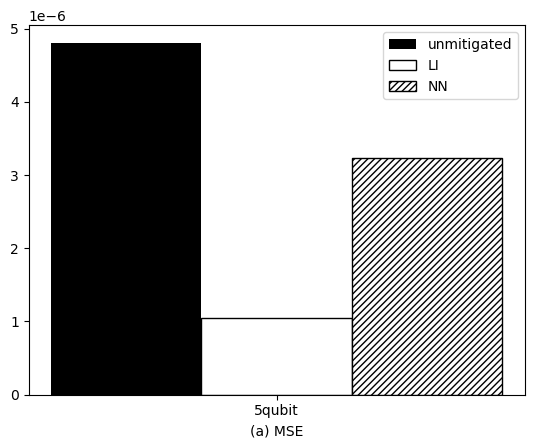

In [475]:
topics = ['5qubit']
label = ['unmitigated', 'LI', 'NN']
show_plot(topics, unmitigated_res, LI_res, NN_res, 0, label)

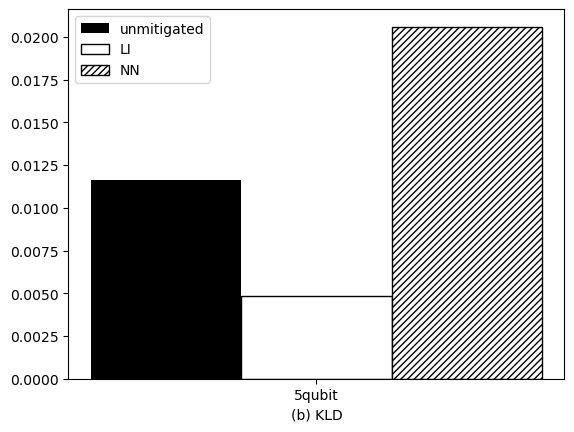

In [59]:
show_plot(topics, unmitigated_res, LI_res, NN_res, 1, label)

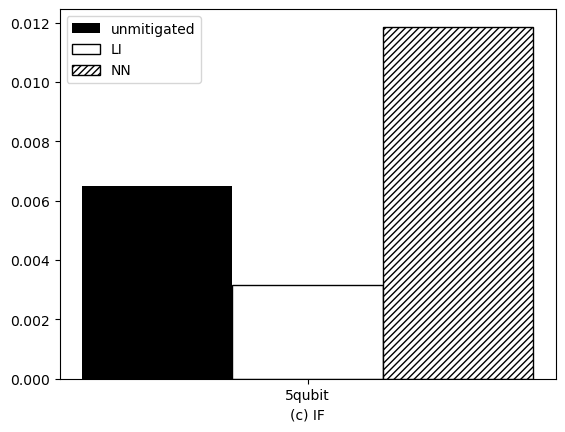

In [60]:
show_plot(topics, unmitigated_res, LI_res, NN_res, 2, label)

## conditional independent NN

In [321]:
def get_train_test_1(x, y, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    
    return train_x, test_x, train_y, test_y 

In [548]:
x_gfe_given_d0 = pd.read_csv("ibm_lagos_7qubits_obs_gfe_given_d0.csv") 
x_cba_given_d0 = pd.read_csv("ibm_lagos_7qubits_obs_cba_given_d0.csv") 
x_gfe_given_d1 = pd.read_csv("ibm_lagos_7qubits_obs_gfe_given_d1.csv") 
x_cba_given_d1 = pd.read_csv("ibm_lagos_7qubits_obs_cba_given_d1.csv") 

y_gfe_given_d0 = pd.read_csv("ibm_lagos_7qubits_ideal_gfe_given_d0.csv") 
y_cba_given_d0 = pd.read_csv("ibm_lagos_7qubits_ideal_cba_given_d0.csv") 
y_gfe_given_d1 = pd.read_csv("ibm_lagos_7qubits_ideal_gfe_given_d1.csv") 
y_cba_given_d1 = pd.read_csv("ibm_lagos_7qubits_ideal_cba_given_d1.csv") 

x_d = pd.read_csv("ibm_lagos_7qubits_obs_d.csv") 
y_d = pd.read_csv("ibm_lagos_7qubits_ideal_d.csv") 


In [549]:
trainX_gfe_given_d0, testX_gfe_given_d0, trainY_gfe_given_d0, testY_gfe_given_d0 = get_train_test_1(x_gfe_given_d0, y_gfe_given_d0, n_train_data, random_state = 7)
trainX_cba_given_d0, testX_cba_given_d0, trainY_cba_given_d0, testY_cba_given_d0 = get_train_test_1(x_cba_given_d0, y_cba_given_d0, n_train_data, random_state = 7)
trainX_gfe_given_d1, testX_gfe_given_d1, trainY_gfe_given_d1, testY_gfe_given_d1 = get_train_test_1(x_gfe_given_d1, y_gfe_given_d1, n_train_data, random_state = 7)
trainX_cba_given_d1, testX_cba_given_d1, trainY_cba_given_d1, testY_cba_given_d1 = get_train_test_1(x_cba_given_d1, y_cba_given_d1, n_train_data, random_state = 7)

trainX_d, testX_d, trainY_d, testY_d = get_train_test_1(x_d, y_d, n_train_data, random_state = 7)


In [550]:
n_train_data = 2400

miti_0 = []
l = [4]
for hidden in l:
    model = NN_model(n_qubit = 3, n_hidden_layer = hidden, n_nodes = 5, activation = 'selu')

    adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    model.fit(trainX_gfe_given_d0, trainY_gfe_given_d0, epochs = 300, batch_size = 16)

    miti_0.append(model.predict(testX_gfe_given_d0))

Epoch 1/300
150/150 [==============================] - 1s 1ms/step - loss: 2.1261 - accuracy: 0.2427
Epoch 2/300
150/150 [==============================] - 0s 881us/step - loss: 1.6982 - accuracy: 0.7887
Epoch 3/300
150/150 [==============================] - 0s 815us/step - loss: 1.5743 - accuracy: 0.9177
Epoch 4/300
150/150 [==============================] - 0s 960us/step - loss: 1.5477 - accuracy: 0.9406
Epoch 5/300
150/150 [==============================] - 0s 744us/step - loss: 1.5443 - accuracy: 0.9585
Epoch 6/300
150/150 [==============================] - 0s 774us/step - loss: 1.5374 - accuracy: 0.9571
Epoch 7/300
150/150 [==============================] - 0s 711us/step - loss: 1.5370 - accuracy: 0.9530
Epoch 8/300
150/150 [==============================] - 0s 757us/step - loss: 1.5301 - accuracy: 0.9521
Epoch 9/300
150/150 [==============================] - 0s 819us/step - loss: 1.5373 - accuracy: 0.9599
Epoch 10/300
150/150 [==============================] - 0s 815us/step - los

In [551]:
# trainX_cba_given_d0, testX_cba_given_d0, trainY_cba_given_d0, testY_cba_given_d0 = get_train_test_1(x_cba_given_d0, y_cba_given_d0, n_train_data, random_state = 7)

miti_1 = []
l = [4]
for hidden in l:
    model = NN_model(n_qubit = 3, n_hidden_layer = hidden, n_nodes = 5, activation = 'selu')

    adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    model.fit(trainX_cba_given_d0, trainY_cba_given_d0, epochs = 300, batch_size = 16)

    miti_1.append(model.predict(testX_cba_given_d0))

Epoch 1/300
150/150 [==============================] - 1s 1ms/step - loss: 1.9784 - accuracy: 0.3193
Epoch 2/300
150/150 [==============================] - 0s 1ms/step - loss: 1.6393 - accuracy: 0.8638
Epoch 3/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5409 - accuracy: 0.9279
Epoch 4/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5342 - accuracy: 0.9476
Epoch 5/300
150/150 [==============================] - 0s 944us/step - loss: 1.5323 - accuracy: 0.9568
Epoch 6/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5314 - accuracy: 0.9598
Epoch 7/300
150/150 [==============================] - 0s 987us/step - loss: 1.5251 - accuracy: 0.9613
Epoch 8/300
150/150 [==============================] - 0s 923us/step - loss: 1.5145 - accuracy: 0.9608
Epoch 9/300
150/150 [==============================] - 0s 980us/step - loss: 1.5160 - accuracy: 0.9586
Epoch 10/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5088 

In [552]:
# trainX_gfe_given_d1, testX_gfe_given_d1, trainY_gfe_given_d1, testY_gfe_given_d1 = get_train_test_1(x_gfe_given_d1, y_gfe_given_d1, n_train_data, random_state = 7)

miti_2 = []
l = [4]
for hidden in l:
    model = NN_model(n_qubit = 3, n_hidden_layer = hidden, n_nodes = 5, activation = 'selu')

    adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    model.fit(trainX_gfe_given_d1, trainY_gfe_given_d1, epochs = 300, batch_size = 16)

    miti_2.append(model.predict(testX_gfe_given_d1))

Epoch 1/300
150/150 [==============================] - 1s 1ms/step - loss: 2.0335 - accuracy: 0.2545
Epoch 2/300
150/150 [==============================] - 0s 1ms/step - loss: 1.6913 - accuracy: 0.8336
Epoch 3/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5653 - accuracy: 0.9270
Epoch 4/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5420 - accuracy: 0.9465
Epoch 5/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5375 - accuracy: 0.9542
Epoch 6/300
150/150 [==============================] - 0s 913us/step - loss: 1.5438 - accuracy: 0.9532
Epoch 7/300
150/150 [==============================] - 0s 960us/step - loss: 1.5335 - accuracy: 0.9638
Epoch 8/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5420 - accuracy: 0.9508
Epoch 9/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5231 - accuracy: 0.9568
Epoch 10/300
150/150 [==============================] - 0s 937us/step - loss: 1.5432 - 

In [553]:
# trainX_cba_given_d1, testX_cba_given_d1, trainY_cba_given_d1, testY_cba_given_d1 = get_train_test_1(x_cba_given_d1, y_cba_given_d1, n_train_data, random_state = 7)

miti_3 = []
l = [4]
for hidden in l:
    model = NN_model(n_qubit = 3, n_hidden_layer = hidden, n_nodes = 5, activation = 'selu')

    adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    model.fit(trainX_cba_given_d1, trainY_cba_given_d1, epochs = 300, batch_size = 16)

    miti_3.append(model.predict(testX_cba_given_d1))

Epoch 1/300
150/150 [==============================] - 1s 1ms/step - loss: 1.9048 - accuracy: 0.4598
Epoch 2/300
150/150 [==============================] - 0s 967us/step - loss: 1.5975 - accuracy: 0.8730
Epoch 3/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5329 - accuracy: 0.9595
Epoch 4/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5353 - accuracy: 0.9522
Epoch 5/300
150/150 [==============================] - 0s 993us/step - loss: 1.5223 - accuracy: 0.9618
Epoch 6/300
150/150 [==============================] - 0s 936us/step - loss: 1.5295 - accuracy: 0.9528
Epoch 7/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5203 - accuracy: 0.9593
Epoch 8/300
150/150 [==============================] - 0s 1ms/step - loss: 1.5288 - accuracy: 0.9674
Epoch 9/300
150/150 [==============================] - 0s 932us/step - loss: 1.5105 - accuracy: 0.9591
Epoch 10/300
150/150 [==============================] - 0s 979us/step - loss: 1.528

In [554]:
# trainX_d, testX_d, trainY_d, testY_d = get_train_test_1(x_d, y_d, n_train_data, random_state = 7)

miti_4 = []
l = [4]
for hidden in l:
    model = NN_model(n_qubit = 1, n_hidden_layer = hidden, n_nodes = 5, activation = 'selu')

    adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    model.fit(trainX_d, trainY_d, epochs = 300, batch_size = 16)

    miti_4.append(model.predict(testX_d))

Epoch 1/300
150/150 [==============================] - 1s 925us/step - loss: 0.6351 - accuracy: 0.8936
Epoch 2/300
150/150 [==============================] - 0s 933us/step - loss: 0.5715 - accuracy: 0.9760
Epoch 3/300
150/150 [==============================] - 0s 913us/step - loss: 0.5285 - accuracy: 0.9918
Epoch 4/300
150/150 [==============================] - 0s 921us/step - loss: 0.5152 - accuracy: 0.9920
Epoch 5/300
150/150 [==============================] - 0s 1ms/step - loss: 0.5144 - accuracy: 0.9935
Epoch 6/300
150/150 [==============================] - 0s 967us/step - loss: 0.5096 - accuracy: 0.9884
Epoch 7/300
150/150 [==============================] - 0s 811us/step - loss: 0.5080 - accuracy: 0.9861
Epoch 8/300
150/150 [==============================] - 0s 797us/step - loss: 0.5066 - accuracy: 0.9897
Epoch 9/300
150/150 [==============================] - 0s 787us/step - loss: 0.5084 - accuracy: 0.9914
Epoch 10/300
150/150 [==============================] - 0s 816us/step - los

In [555]:
columns = []
columns_1 = []

for i in range(2**3):
    bit_i = str(bin(i)[2:]).zfill(3)
    columns.append(bit_i)
    
for i in range(2**1):
    bit_i = str(bin(i)[2:]).zfill(1)
    columns_1.append(bit_i)

In [556]:
miti_a0 = pd.DataFrame(miti_0[0], columns = columns)
miti_a1 = pd.DataFrame(miti_1[0], columns = columns)
miti_a2 = pd.DataFrame(miti_2[0], columns = columns)
miti_a3 = pd.DataFrame(miti_3[0], columns = columns)
miti_a4 = pd.DataFrame(miti_4[0], columns = columns_1)

miti_a0 = miti_a0.to_dict('record')
miti_a1 = miti_a1.to_dict('record')
miti_a2 = miti_a2.to_dict('record')
miti_a3 = miti_a3.to_dict('record')
miti_a4 = miti_a4.to_dict('record')

c:\Users\ChangWon\Anaconda3\envs\tf\lib\site-packages\pandas\core\frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [557]:
CI_res = []
for k in range(300):
    prob = {}
    for i in range(2**3):
        bit_i = str(bin(i)[2:]).zfill(3)
        for j in range(2**3):
            bit_j = str(bin(j)[2:]).zfill(3)
            prob[bit_i + '0' + bit_j] = miti_a0[k][bit_i] * miti_a1[k][bit_j] * miti_a4[k]['0']
            prob[bit_i + '1' + bit_j] = miti_a2[k][bit_i] * miti_a3[k][bit_j] * miti_a4[k]['1']
    CI_res.append(prob)

res = pd.DataFrame(CI_res)
res = res.sort_index(axis = 1)


In [558]:
unmitigated_res = []
LI_res = []
NN_res = []
CI_res = []

unmitigated_res.append(loss_function(testY.values, testX.values, n_qubits[0]))
LI_res.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
NN_res.append(loss_function(testY.values, miti[0], n_qubits[0]))
CI_res.append(loss_function(testY.values, res.values, n_qubits[0]))

In [559]:
def show_plot_2(topics, unmitigated, LI, NN, CI, type = 0, label = ['unmitigated', 'LI', 'NN', 'CI']):
    n = 1  # This is our first dataset (out of 2)
    t = 4 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d)
    value_c_x = create_x(t, w, 3, d)
    value_d_x = create_x(t, w, 4, d)

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [LI[0][type]]
    x_3 = [NN[0][type]]
    x_4 = [CI[0][type]]

    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black')
    ax.bar(value_c_x, x_3, label = label[2], color = 'white', edgecolor = 'black', hatch = '/////')
    ax.bar(value_d_x, x_4, label = label[3], color = 'white', edgecolor = 'black', hatch = '/////////')

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks([2])
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()

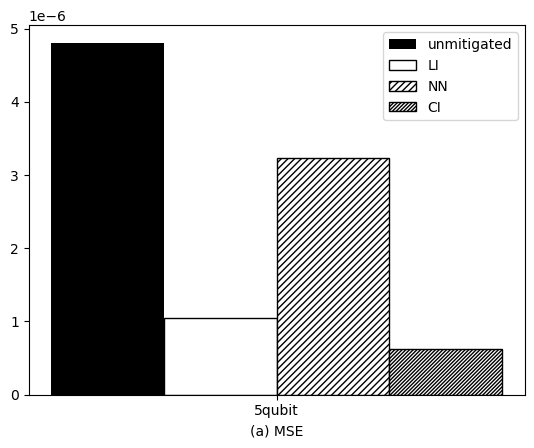

In [560]:
topics = ['5qubit']
label = ['unmitigated', 'LI', 'NN', 'CI']
show_plot_2(topics, unmitigated_res, LI_res, NN_res, CI_res, 0, label)

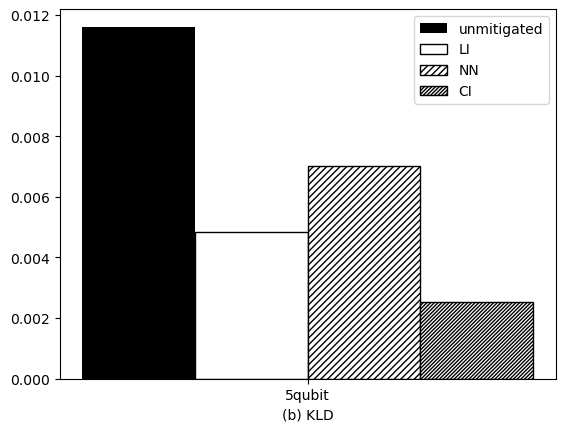

In [561]:
show_plot_2(topics, unmitigated_res, LI_res, NN_res, CI_res, 1, label)

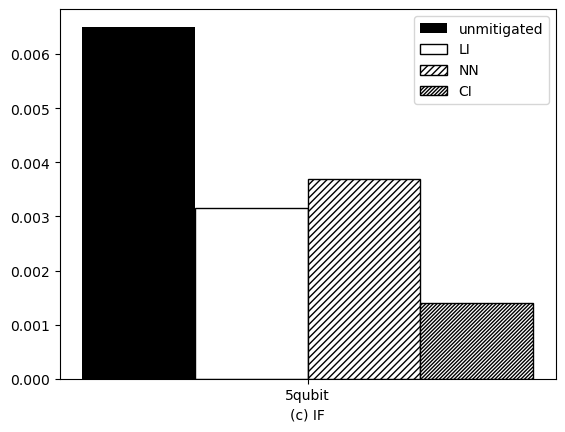

In [562]:
show_plot_2(topics, unmitigated_res, LI_res, NN_res, CI_res, 2, label)